reference codes

In [2]:
"""
The Beer Distribution Problem for the PuLP Modeller

Authors: Antony Phillips, Dr Stuart Mitchell  2007
"""

# Import PuLP modeler functions
from pulp import *

# Creates a list of all the supply nodes
Warehouses = ["A", "B"]

# Creates a dictionary for the number of units of supply for each supply node
supply = {"A": 1000,
          "B": 4000}

# Creates a list of all demand nodes
Bars = ["1", "2", "3", "4", "5"]

# Creates a dictionary for the number of units of demand for each demand node
demand = {"1":500,
          "2":900,
          "3":1800,
          "4":200,
          "5":700,}

# Creates a list of costs of each transportation path
costs = [   #Bars
         #1 2 3 4 5
         [2,4,5,2,1],#A   Warehouses
         [3,1,3,2,3] #B
         ]

# The cost data is made into a dictionary
costs = makeDict([Warehouses,Bars],costs,0)

# Creates the 'prob' variable to contain the problem data
prob = LpProblem("Beer Distribution Problem",LpMinimize)

# Creates a list of tuples containing all the possible routes for transport
Routes = [(w,b) for w in Warehouses for b in Bars]

# A dictionary called 'Vars' is created to contain the referenced variables(the routes)
vars = LpVariable.dicts("Route",(Warehouses,Bars),0,None,LpInteger)

# The objective function is added to 'prob' first
prob += lpSum([vars[w][b]*costs[w][b] for (w,b) in Routes]), "Sum_of_Transporting_Costs"

# The supply maximum constraints are added to prob for each supply node (warehouse)
for w in Warehouses:
    prob += lpSum([vars[w][b] for b in Bars])<=supply[w], "Sum_of_Products_out_of_Warehouse_%s"%w

# The demand minimum constraints are added to prob for each demand node (bar)
for b in Bars:
    prob += lpSum([vars[w][b] for w in Warehouses])>=demand[b], "Sum_of_Products_into_Bar%s"%b
                   
# The problem data is written to an .lp file
prob.writeLP("BeerDistributionProblem.lp")

# The problem is solved using PuLP's choice of Solver
prob.solve()

# The status of the solution is printed to the screen
print("Status:", LpStatus[prob.status])

# Each of the variables is printed with it's resolved optimum value
for v in prob.variables():
    print(v.name, "=", v.varValue)

# The optimised objective function value is printed to the screen    
print("Total Cost of Transportation = ", value(prob.objective))

Status: Optimal
Route_A_1 = 300.0
Route_A_2 = 0.0
Route_A_3 = 0.0
Route_A_4 = 0.0
Route_A_5 = 700.0
Route_B_1 = 200.0
Route_B_2 = 900.0
Route_B_3 = 1800.0
Route_B_4 = 200.0
Route_B_5 = 0.0
Total Cost of Transportation =  8600.0


/Users/clause/Anaconda/anaconda3/envs/ML/lib/python3.8/site-packages/pulp/pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [3]:
import itertools

import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import pulp

import warnings
warnings.filterwarnings("ignore")

In [15]:
# define TSP

n_customer = 5
n_point = n_customer + 1

df = pd.DataFrame({
    'x': np.random.randint(0, 100, n_point),
    'y': np.random.randint(0, 100, n_point),
})

df.iloc[0]['x'] = 0
df.iloc[0]['y'] = 0

df

,x,y
0,0,0
1,24,93
2,41,17
3,26,1
4,29,20
5,76,87


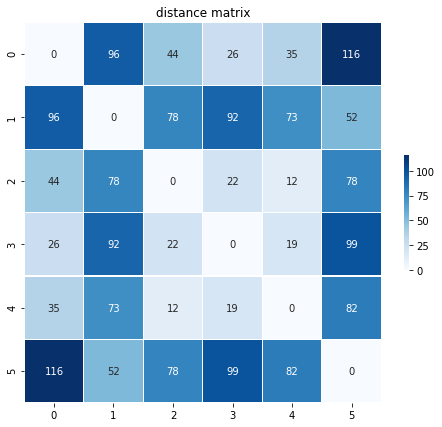

[[  0.          96.04686356  44.38468204  26.01922366  35.22782991
  115.52056094]
 [ 96.04686356   0.          77.87810989  92.02173656  73.17103252
   52.34500931]
 [ 44.38468204  77.87810989   0.          21.9317122   12.36931688
   78.26237921]
 [ 26.01922366  92.02173656  21.9317122    0.          19.23538406
   99.47864092]
 [ 35.22782991  73.17103252  12.36931688  19.23538406   0.
   81.84130986]
 [115.52056094  52.34500931  78.26237921  99.47864092  81.84130986
    0.        ]]


In [16]:
# get distance matrix

distances = pd.DataFrame(distance_matrix(df[['x', 'y']].values, df[['x', 'y']].values), index=df.index, columns=df.index).values

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(distances, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
plt.title('distance matrix')
plt.show()

print(distances)

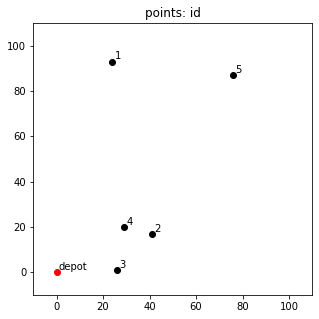

In [17]:
# check TSP state

plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'depot')
    else:
        plt.scatter(row['x'], row['y'], c='black')
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}')
        
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id')
plt.show()

In [18]:
%%time

# set problem
problem = pulp.LpProblem('tsp_mip', pulp.LpMinimize)

# set valiables
x = pulp.LpVariable.dicts('x', ((i, j) for i in range(n_point) for j in range(n_point)), lowBound=0, upBound=1, cat='Binary')
# we need to keep track of the order in the tour to eliminate the possibility of subtours
u = pulp.LpVariable.dicts('u', (i for i in range(n_point)), lowBound=1, upBound=n_point, cat='Integer')

# set objective function
problem += pulp.lpSum(distances[i][j] * x[i, j] for i in range(n_point) for j in range(n_point))

# set constrains
for i in range(n_point):
    problem += x[i, i] == 0

for i in range(n_point):
    problem += pulp.lpSum(x[i, j] for j in range(n_point)) == 1
    problem += pulp.lpSum(x[j, i] for j in range(n_point)) == 1

# eliminate subtour
for i in range(n_point):
    for j in range(n_point):
        if i != j and (i != 0 and j != 0):
            problem += u[i] - u[j] <= n_point * (1 - x[i, j]) - 1
            
# solve problem
status = problem.solve()

# output status, value of objective function
status, pulp.LpStatus[status], pulp.value(problem.objective)

CPU times: user 6.92 ms, sys: 19.4 ms, total: 26.3 ms
Wall time: 222 ms


(1, 'Optimal', 284.2781766882347)

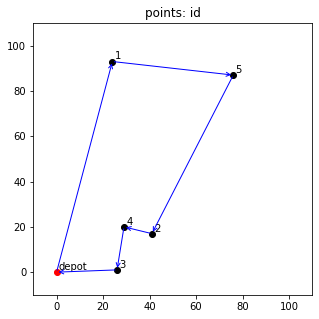

In [14]:
# check TSP problem and optimized route

plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'depot')
        
    else:
        plt.scatter(row['x'], row['y'], c='black')
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}')
        
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id')

# draw optimal route
routes = [(i, j) for i in range(n_point) for j in range(n_point) if pulp.value(x[i, j]) == 1]
arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
for i, j in routes:
    plt.annotate('', xy=[df.iloc[j]['x'], df.iloc[j]['y']], xytext=[df.iloc[i]['x'], df.iloc[i]['y']], arrowprops=arrowprops)
                
plt.show()

number of cities : 50
{(1, 2): 80, (1, 3): 29, (1, 4): 162, (1, 5): 133, (1, 6): 66, (1, 7): 51, (1, 8): 164, (1, 9): 129, (1, 10): 149, (1, 11): 16, (1, 12): 70, (1, 13): 28, (1, 14): 123, (1, 15): 53, (1, 16): 52, (1, 17): 41, (1, 18): 126, (1, 19): 99, (1, 20): 136, (1, 21): 83, (1, 22): 30, (1, 23): 117, (1, 24): 100, (1, 25): 14, (1, 26): 54, (1, 27): 109, (1, 28): 72, (1, 29): 69, (1, 30): 145, (1, 31): 109, (1, 32): 123, (1, 33): 28, (1, 34): 16, (1, 35): 122, (1, 36): 90, (1, 37): 64, (1, 38): 130, (1, 39): 94, (1, 40): 122, (1, 41): 73, (1, 42): 117, (1, 43): 38, (1, 44): 64, (1, 45): 55, (1, 46): 163, (1, 47): 14, (1, 48): 31, (1, 49): 82, (1, 50): 210, (2, 1): 80, (2, 3): 85, (2, 4): 166, (2, 5): 200, (2, 6): 28, (2, 7): 55, (2, 8): 244, (2, 9): 109, (2, 10): 96, (2, 11): 82, (2, 12): 143, (2, 13): 106, (2, 14): 90, (2, 15): 132, (2, 16): 119, (2, 17): 91, (2, 18): 198, (2, 19): 167, (2, 20): 172, (2, 21): 130, (2, 22): 64, (2, 23): 108, (2, 24): 163, (2, 25): 94, (2, 26): 1

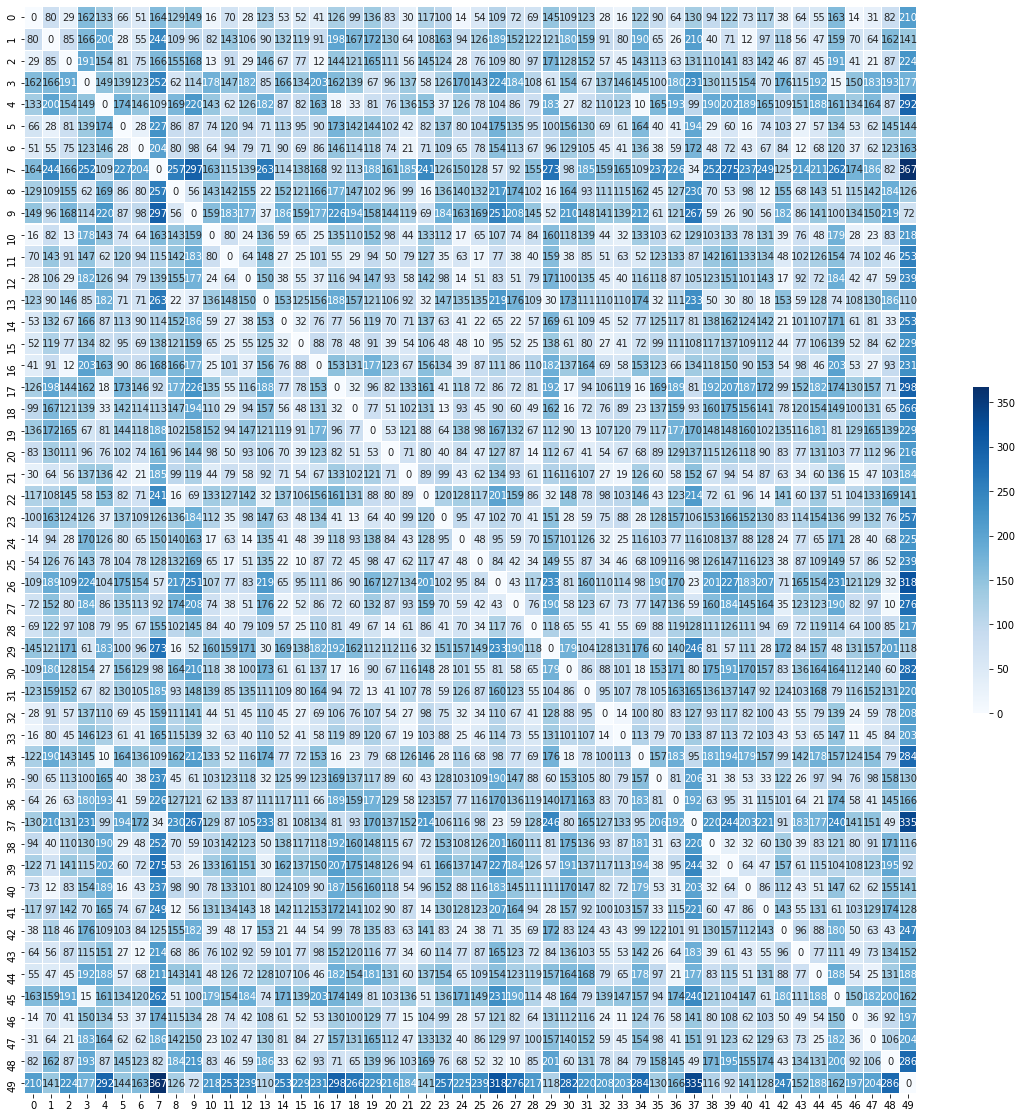

In [21]:
from TSP_C1 import *
import pulp
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns

print("number of cities : {}".format(len(cities_C1)))

n_point = len(cities_C1)

for i in range(1,n_point+1):
    dist_C1[i,i]=0

print(dist_C1)
dist = sorted(dist_C1.keys())


distances = np.array([dist_C1[i] for i in dist])
distances = distances.reshape([50,50])

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(distances, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
plt.show()